In [199]:
from collections import defaultdict

import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate
from xgboost import XGBClassifier
from ta import add_all_ta_features
from sklearn.feature_selection import RFE
import xgboost as xgb

In [200]:
WINDOW = 8 # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
INTERVAL = '1y'     # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
symbol = 'AAPL'      # Symbol of the desired stock

# one day 16 rows of data

In [201]:
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = symbol,


        period = INTERVAL,

        interval = FETCH_INTERVAL,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        # auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-05-13 04:00:00-04:00,77.752500,77.975000,77.687500,77.975000,77.975000,0
2020-05-13 05:00:00-04:00,77.975000,78.247500,77.900000,77.977500,77.977500,0
2020-05-13 06:00:00-04:00,77.997500,78.270000,77.997500,78.245000,78.245000,0
2020-05-13 07:00:00-04:00,78.205000,78.297500,78.017500,78.112500,78.112500,0
2020-05-13 08:00:00-04:00,78.117500,78.500000,78.005000,78.322500,78.322500,0
...,...,...,...,...,...,...
2021-05-12 14:30:00-04:00,122.510002,122.959999,122.260002,122.470001,122.470001,10802679
2021-05-12 15:30:00-04:00,122.474998,123.059998,122.300003,122.820000,122.820000,14469408
2021-05-12 16:00:00-04:00,122.820000,123.090000,122.345000,122.400000,122.400000,10328874


In [202]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)
important_columns = ['open', 'high', 'low','close','volume']

In [203]:

def calculate_diffs(diff_number, col_name):
    new_col_name = f'{col_name}_{diff_number}'
    data[new_col_name] = data[col_name].diff(diff_number)

In [204]:
# for name in important_columns:
#     for i in range(1, 11):
#         calculate_diffs(i, name)
#
# data.head(10)

In [205]:
data = data.dropna()

<AxesSubplot:xlabel='Datetime'>

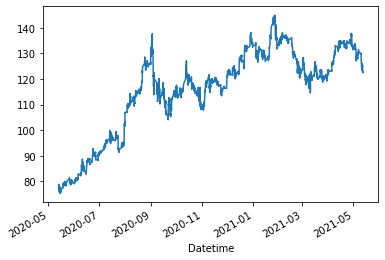

In [206]:
data['close'].plot()

In [207]:
data['close_pct'] = data['close'].pct_change()
data.head()

,open,high,low,close,Adj Close,volume,close_pct
Datetime,,,,,,,
2020-05-13 04:00:00-04:00,77.7525,77.9750,77.6875,77.9750,77.9750,0,NaN
2020-05-13 05:00:00-04:00,77.9750,78.2475,77.9000,77.9775,77.9775,0,0.000032
2020-05-13 06:00:00-04:00,77.9975,78.2700,77.9975,78.2450,78.2450,0,0.003430
2020-05-13 07:00:00-04:00,78.2050,78.2975,78.0175,78.1125,78.1125,0,-0.001693
2020-05-13 08:00:00-04:00,78.1175,78.5000,78.0050,78.3225,78.3225,0,0.002688


In [208]:
data.describe()

,open,high,low,close,Adj Close,volume,close_pct
count,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000,4.186000e+03,4185.000000
mean,115.493901,116.038469,114.848343,115.491461,115.491461,5.084074e+06,0.000123
std,16.806775,17.647017,16.758043,16.794203,16.794203,8.587058e+06,0.005410
min,75.087502,75.537500,58.360000,75.300000,75.300000,0.000000e+00,-0.051319
25%,109.368125,109.759900,108.671249,109.333414,109.333414,0.000000e+00,-0.001888
50%,119.645451,120.100000,118.811249,119.634950,119.634950,0.000000e+00,0.000089
75%,128.275025,128.703751,127.591800,128.269627,128.269627,8.382402e+06,0.002265
max,144.900000,438.440000,144.590000,144.910000,144.910000,9.845401e+07,0.051457


In [209]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    data = add_all_ta_features(
        data, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    # data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()
    # for i in range(1,50):
    #     data[f'close{i}'] = data['close'].shift(i)
    # Remove columns that won't be used as features
    # del (data['Adj Close'])

    return data


In [210]:
data

,open,high,low,close,Adj Close,volume,close_pct
Datetime,,,,,,,
2020-05-13 04:00:00-04:00,77.752500,77.975000,77.687500,77.975000,77.975000,0,NaN
2020-05-13 05:00:00-04:00,77.975000,78.247500,77.900000,77.977500,77.977500,0,0.000032
2020-05-13 06:00:00-04:00,77.997500,78.270000,77.997500,78.245000,78.245000,0,0.003430
2020-05-13 07:00:00-04:00,78.205000,78.297500,78.017500,78.112500,78.112500,0,-0.001693
2020-05-13 08:00:00-04:00,78.117500,78.500000,78.005000,78.322500,78.322500,0,0.002688
...,...,...,...,...,...,...,...
2021-05-12 14:30:00-04:00,122.510002,122.959999,122.260002,122.470001,122.470001,10802679,-0.000327
2021-05-12 15:30:00-04:00,122.474998,123.059998,122.300003,122.820000,122.820000,14469408,0.002858
2021-05-12 16:00:00-04:00,122.820000,123.090000,122.345000,122.400000,122.400000,10328874,-0.003420


In [211]:
data.columns

Index(['open', 'high', 'low', 'close', 'Adj Close', 'volume', 'close_pct'], dtype='object')

In [212]:
def create_class_column(row, lowest_threshold, higher_threshold):
    if row['close_shift'] - row['close'] > higher_threshold:
        return 1
    if row['close_shift'] - row['close'] < lowest_threshold:
        return -1
    else:
        return 0

In [213]:
data = _get_indicator_data(data)
data['close_shift'] = data.shift(-WINDOW)['close']
data

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


,open,high,low,close,Adj Close,volume,close_pct,volume_adi,volume_obv,volume_cmf,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-05-13 04:00:00-04:00,77.752500,77.975000,77.687500,77.975000,77.975000,0,NaN,0.000000e+00,0,0.000000,...,0.000000,77.975000,0.000000,0.000000,0.000000,0.000000,-32.484186,0.000000,0.000000,76.611198
2020-05-13 05:00:00-04:00,77.975000,78.247500,77.900000,77.977500,77.977500,0,0.000032,0.000000e+00,0,0.000000,...,0.000000,77.976139,0.000000,0.000000,0.000000,0.000000,0.003206,0.003206,0.003206,76.374977
2020-05-13 06:00:00-04:00,77.997500,78.270000,77.997500,78.245000,78.245000,0,0.003430,0.000000e+00,0,0.000000,...,0.000000,78.094432,0.000000,0.000000,0.000000,0.000000,0.343048,0.342461,0.346265,76.417747
2020-05-13 07:00:00-04:00,78.205000,78.297500,78.017500,78.112500,78.112500,0,-0.001693,0.000000e+00,0,0.000000,...,0.000000,78.102394,0.000000,0.000000,0.000000,0.000000,-0.169340,-0.169483,0.176339,76.184998
2020-05-13 08:00:00-04:00,78.117500,78.500000,78.005000,78.322500,78.322500,0,0.002688,0.000000e+00,0,0.000000,...,0.000000,78.196385,0.000000,0.000000,0.000000,0.000000,0.268843,0.268482,0.445656,76.919998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-12 14:30:00-04:00,122.510002,122.959999,122.260002,122.470001,122.470001,10802679,-0.000327,6.306123e+08,-513565942,-0.125334,...,-1.667697,122.932708,-2.585109,20.805708,5.964983,14.840725,-0.032651,-0.032656,57.063163,NaN
2021-05-12 15:30:00-04:00,122.474998,123.059998,122.300003,122.820000,122.820000,14469408,0.002858,6.359432e+08,-499096534,-0.139414,...,-1.656080,122.911653,-1.900959,23.803451,9.532677,14.270774,0.285783,0.285375,57.512023,NaN
2021-05-12 16:00:00-04:00,122.820000,123.090000,122.345000,122.400000,122.400000,10328874,-0.003420,6.271393e+08,-509425408,-0.278977,...,-1.677024,122.764612,-2.166094,22.216890,12.069519,10.147371,-0.341964,-0.342550,56.973389,NaN


In [214]:
def create_class(df):
    higher_threshold = 1.5
    lowest_threshold = -1.5
    last_values_higher = []
    last_values_lower = []
    df['class_column'] = df.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)
    while True:
        class_counts = df['class_column'].value_counts()
        if abs(class_counts[0] - class_counts[1]) < 15 and abs(class_counts[0] - class_counts[-1]) < 15:
            break

        if len(last_values_higher) == 3:
            last_values_higher.pop(0)
        if len(last_values_lower) == 3:
            last_values_lower.pop(0)

        last_values_higher.append(higher_threshold)
        last_values_lower.append(lowest_threshold)
        if class_counts[0] > class_counts[1]:
            higher_threshold -= 0.01
        if class_counts[0] > class_counts[-1]:
            lowest_threshold += 0.01
        if class_counts[0] < class_counts[1]:
            higher_threshold += 0.01
        if class_counts[0] < class_counts[-1]:
            lowest_threshold -= 0.01

        if higher_threshold in last_values_higher and lowest_threshold in last_values_lower:
            break
        df['class_column'] = df.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)),
                                          axis=1)
    print(df['class_column'].value_counts())
    return df


data = create_class(data)

data


 1    1397
-1    1396
 0    1393
Name: class_column, dtype: int64


,open,high,low,close,Adj Close,volume,close_pct,volume_adi,volume_obv,volume_cmf,...,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift,class_column
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-05-13 04:00:00-04:00,77.752500,77.975000,77.687500,77.975000,77.975000,0,NaN,0.000000e+00,0,0.000000,...,77.975000,0.000000,0.000000,0.000000,0.000000,-32.484186,0.000000,0.000000,76.611198,-1
2020-05-13 05:00:00-04:00,77.975000,78.247500,77.900000,77.977500,77.977500,0,0.000032,0.000000e+00,0,0.000000,...,77.976139,0.000000,0.000000,0.000000,0.000000,0.003206,0.003206,0.003206,76.374977,-1
2020-05-13 06:00:00-04:00,77.997500,78.270000,77.997500,78.245000,78.245000,0,0.003430,0.000000e+00,0,0.000000,...,78.094432,0.000000,0.000000,0.000000,0.000000,0.343048,0.342461,0.346265,76.417747,-1
2020-05-13 07:00:00-04:00,78.205000,78.297500,78.017500,78.112500,78.112500,0,-0.001693,0.000000e+00,0,0.000000,...,78.102394,0.000000,0.000000,0.000000,0.000000,-0.169340,-0.169483,0.176339,76.184998,-1
2020-05-13 08:00:00-04:00,78.117500,78.500000,78.005000,78.322500,78.322500,0,0.002688,0.000000e+00,0,0.000000,...,78.196385,0.000000,0.000000,0.000000,0.000000,0.268843,0.268482,0.445656,76.919998,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-12 14:30:00-04:00,122.510002,122.959999,122.260002,122.470001,122.470001,10802679,-0.000327,6.306123e+08,-513565942,-0.125334,...,122.932708,-2.585109,20.805708,5.964983,14.840725,-0.032651,-0.032656,57.063163,NaN,0
2021-05-12 15:30:00-04:00,122.474998,123.059998,122.300003,122.820000,122.820000,14469408,0.002858,6.359432e+08,-499096534,-0.139414,...,122.911653,-1.900959,23.803451,9.532677,14.270774,0.285783,0.285375,57.512023,NaN,0
2021-05-12 16:00:00-04:00,122.820000,123.090000,122.345000,122.400000,122.400000,10328874,-0.003420,6.271393e+08,-509425408,-0.278977,...,122.764612,-2.166094,22.216890,12.069519,10.147371,-0.341964,-0.342550,56.973389,NaN,0


In [215]:
filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\train_test\\{symbol}_{INTERVAL}_{WINDOW}_diff_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}_full.csv'
data.to_csv(filename_to_export, index=True)
print(filename_to_export)

C:\Users\exomat\Desktop\repo\magisterka_analiza\data\results\train_test\AAPL_1y_8_diff_13_05_2021 00_26_31_full.csv


In [216]:

# Class divide
data['class_column'].value_counts()

 1    1397
-1    1396
 0    1393
Name: class_column, dtype: int64

In [217]:
# del (data['close'])
# del (data['close_shift'])
data = data.dropna()

In [218]:
data['class_column'].value_counts()


 1    1397
-1    1395
 0    1385
Name: class_column, dtype: int64

In [219]:
def split_dataframe(df, chunk_size = 17):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

def train_model(model,train_x, train_y):
    model.fit(train_x, train_y)

In [220]:
splited_dataframe = split_dataframe(data, 17)
len(splited_dataframe)

246

In [221]:
y = data['class_column']
features = [x for x in data.columns if x not in ['class_column', 'close_shift']]
x = data[features]
scaler = MinMaxScaler()
# x = pd.DataFrame(scaler.fit_transform(x.values), columns=x.columns, index=x.index)
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

In [222]:
classifiers = dict()

classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='best')
classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(max_depth=20, random_state=0,criterion='gini',splitter='best')
classifiers['DecisionTreeClassifier 3'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='random')
classifiers['DecisionTreeClassifier 4'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='best')
classifiers['DecisionTreeClassifier 5'] = DecisionTreeClassifier(max_depth=15, random_state=0,criterion='entropy',splitter='best')
classifiers['RandomForestClassifier 4'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='gini', n_jobs = -1)
classifiers['RandomForestClassifier 5'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='entropy', n_jobs = -1)
classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=10, learning_rate=0.3)
classifiers['GradientBoostingClassifier 3'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers['XGBClassifier 1'] = xgb.XGBClassifier(nthread =-1,max_depth=10,n_estimators=1000, eta =0.2)
classifiers['XGBClassifier 2'] = xgb.XGBClassifier(nthread =-1,max_depth=14,n_estimators=1000, eta =0.3)
classifiers['XGBClassifier 3'] = xgb.XGBClassifier(nthread =-1,max_depth=14,n_estimators=1000, eta =0.2)
classifiers['XGBClassifier 4'] = xgb.XGBClassifier(nthread =-1,max_depth=10,n_estimators=1000, eta =0.5)
classifiers['XGBClassifier 5'] = xgb.XGBClassifier(nthread =-1,max_depth=6,n_estimators=1000, eta =0.3)
classifiers['XGBClassifier 6'] = xgb.XGBClassifier(nthread =-1,max_depth=3,n_estimators=1000, eta =0.3)
classifiers['XGBRFClassifier 1'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1,max_depth=12,n_estimators =100,eta=0.4)
classifiers['XGBRFClassifier 2'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1,max_depth=14,n_estimators =100,eta=0.4)
classifiers['XGBRFClassifier 3'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1,max_depth=3,n_estimators =1000,eta=0.2)
classifiers['XGBRFClassifier 4'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1,max_depth=6,n_estimators =1000,eta=0.2)
classifiers['XGBRFClassifier 5'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1,max_depth=10,n_estimators =1000,eta=0.2)
classifiers['XGBRFClassifier 6'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1,max_depth=10,n_estimators =100,eta=0.4)
classifiers_boosted = dict()
classifiers_boosted['GradientBoostingClassifier 1S'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers_boosted['GradientBoostingClassifier 2S'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
classifiers_boosted['GradientBoostingClassifier 3S'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.5)
# classifiers_boosted['GradientBoostingClassifier 4S'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.8)



In [223]:
def count_correct(pred_list, original_list):
    correct  = 0
    all  = len(pred_list)
    for idx , el in enumerate(pred_list):
        if el == 1:
            if original_list[idx] == 1:
                correct +=1

    return correct, all


In [224]:
start_data = splited_dataframe[:100]
next_data = splited_dataframe[100:105]
print(len(next_data))
score = defaultdict(list)
points = defaultdict(list)
points_train = defaultdict(list)
score_train = defaultdict(list)
step_headers = []
i = 0
print("start")
for idx, day in enumerate(next_data):
    start_data.append(day)
    data_set = pd.concat(start_data)
    data_set = create_class(data_set)
    print(data_set['class_column'].value_counts())
    y = data_set['class_column']
    features = [x for x in data_set.columns if x not in ['class_column']]
    x = data_set[features]
    x_train= x.iloc[:-17]
    y_train= y.iloc[:-17]
    x_test =x.iloc[-17:]
    y_test=y.iloc[-17:]

    print(len(data_set))

    step_headers.append(f'<{i}>')
    i= i +1
    predictions_train= dict()
    predictions= dict()

    for k,v in classifiers.items():
        print("Calculate: ", k)
        train_model(v,x_train,y_train)
        predictions_train[k] = v.predict(x_train)
        score_train[k].append(accuracy_score(y_train.values, predictions_train[k]))
        predictions[k] = v.predict(x_test)
        score[k].append(accuracy_score(y_test.values, predictions[k]))
        points_train[k].append(count_correct(predictions_train[k],y_train.values))
        points[k].append(count_correct(predictions[k],y_test.values))
        print(accuracy_score(y_test.values, predictions[k]))

    rfe = RFE(classifiers['RandomForestClassifier 5'],10)
    fited = rfe.fit(x_train, y_train)
    names = x.columns
    columns=[]
    for i in range(len(fited.support_)):
        if fited.support_[i]:
            columns.append(names[i])

    print("Columns with predictive power:", columns )
    columns = columns + ['high', 'low', 'volume', 'open']
    x_test_cropped = x_test[columns]
    x_train_cropped = x_train[columns]
    for k,v in classifiers_boosted.items():
        print("Calculate: ", k)
        train_model(v,x_train_cropped,y_train)
        predictions_train[k] = v.predict(x_train_cropped)
        score_train[k].append( accuracy_score(y_train.values, predictions_train[k]))
        predictions[k] = v.predict(x_test_cropped)
        score[k].append(accuracy_score(y_test.values, predictions[k]))
        points_train[k].append(count_correct(predictions_train[k],y_train.values))
        points[k].append(count_correct(predictions[k],y_test.values))
        print(accuracy_score(y_test.values, predictions[k]))




5
start
 1    582
-1    570
 0    565
Name: class_column, dtype: int64
 1    582
-1    570
 0    565
Name: class_column, dtype: int64
1717
Calculate:  DecisionTreeClassifier 1
0.4117647058823529
Calculate:  DecisionTreeClassifier 2
0.5294117647058824
Calculate:  DecisionTreeClassifier 3
0.47058823529411764
Calculate:  DecisionTreeClassifier 4
0.5294117647058824
Calculate:  DecisionTreeClassifier 5
0.35294117647058826
Calculate:  RandomForestClassifier 4
0.5294117647058824
Calculate:  RandomForestClassifier 5
0.5294117647058824
Calculate:  GradientBoostingClassifier 1
0.7647058823529411
Calculate:  GradientBoostingClassifier 2
0.6470588235294118
Calculate:  GradientBoostingClassifier 3
0.5882352941176471
Calculate:  XGBClassifier 1
[00:28:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eva

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5294117647058824
Calculate:  XGBClassifier 2
[00:28:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5882352941176471
Calculate:  XGBClassifier 3
[00:28:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5882352941176471
Calculate:  XGBClassifier 4
[00:28:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_fi', 'volatility_atr', 'volatility_bbw', 'volatility_dcw', 'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_kst', 'trend_visual_ichimoku_b', 'trend_aroon_down']
Calculate:  GradientBoostingClassifier 1S
0.5882352941176471
Calculate:  GradientBoostingClassifier 2S
0.35294117647058826
Calculate:  GradientBoostingClassifier 3S
0.35294117647058826
 1    585
-1    578
 0    571
Name: class_column, dtype: int64
 1    585
-1    578
 0    571
Name: class_column, dtype: int64
1734
Calculate:  DecisionTreeClassifier 1
0.17647058823529413
Calculate:  DecisionTreeClassifier 2
0.11764705882352941
Calculate:  DecisionTreeClassifier 3
0.4117647058823529
Calculate:  DecisionTreeClassifier 4
0.35294117647058826
Calculate:  DecisionTreeClassifier 5
0.47058823529411764
Calculate:  RandomForestClassifier 4
0.47058823529411764
Calculate:  RandomForestClassifier 5
0.6470588235294118
Calculate:  GradientBoostingClassifier 1
0.7058823529411765
Calculate:  Grad

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6470588235294118
Calculate:  XGBClassifier 2
[00:32:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7058823529411765
Calculate:  XGBClassifier 3
[00:32:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5882352941176471
Calculate:  XGBClassifier 4
[00:32:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_fi', 'volume_nvi', 'volatility_bbw', 'volatility_dcw', 'volatility_ui', 'trend_macd', 'trend_trix', 'trend_aroon_down', 'trend_aroon_ind', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.9411764705882353
Calculate:  GradientBoostingClassifier 2S
0.7647058823529411
Calculate:  GradientBoostingClassifier 3S
0.7647058823529411
 1    590
-1    581
 0    580
Name: class_column, dtype: int64
 1    590
-1    581
 0    580
Name: class_column, dtype: int64
1751
Calculate:  DecisionTreeClassifier 1
0.23529411764705882
Calculate:  DecisionTreeClassifier 2
0.35294117647058826
Calculate:  DecisionTreeClassifier 3
0.29411764705882354
Calculate:  DecisionTreeClassifier 4
0.35294117647058826
Calculate:  DecisionTreeClassifier 5
0.5294117647058824
Calculate:  RandomForestClassifier 4
0.7647058823529411
Calculate:  RandomForestClassifier 5
0.7647058823529411
Calculate:  GradientBoostingClassifier 1
0.5294117647058824
Calculate:  GradientBoostingClassifi

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.47058823529411764
Calculate:  XGBClassifier 2
[00:35:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.47058823529411764
Calculate:  XGBClassifier 3
[00:36:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824
Calculate:  XGBClassifier 4
[00:36:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogl

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_fi', 'volatility_atr', 'volatility_bbw', 'volatility_dcw', 'volatility_ui', 'trend_macd', 'trend_trix', 'trend_aroon_down', 'trend_aroon_ind', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.47058823529411764
Calculate:  GradientBoostingClassifier 2S
0.4117647058823529
Calculate:  GradientBoostingClassifier 3S
0.29411764705882354
 1    599
 0    585
-1    584
Name: class_column, dtype: int64
 1    599
 0    585
-1    584
Name: class_column, dtype: int64
1768
Calculate:  DecisionTreeClassifier 1
0.47058823529411764
Calculate:  DecisionTreeClassifier 2
0.4117647058823529
Calculate:  DecisionTreeClassifier 3
0.9411764705882353
Calculate:  DecisionTreeClassifier 4
0.4117647058823529
Calculate:  DecisionTreeClassifier 5
0.4117647058823529
Calculate:  RandomForestClassifier 4
0.47058823529411764
Calculate:  RandomForestClassifier 5
0.47058823529411764
Calculate:  GradientBoostingClassifier 1
0.8823529411764706
Calculate:  GradientBoostingCla

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9411764705882353
Calculate:  XGBClassifier 2
[00:39:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8823529411764706
Calculate:  XGBClassifier 3
[00:39:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8235294117647058
Calculate:  XGBClassifier 4
[00:39:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbl', 'volatility_bbw', 'volatility_dcw', 'trend_macd', 'trend_macd_signal', 'trend_trix', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'trend_aroon_ind']
Calculate:  GradientBoostingClassifier 1S
0.47058823529411764
Calculate:  GradientBoostingClassifier 2S
0.7058823529411765
Calculate:  GradientBoostingClassifier 3S
0.6470588235294118
 1    604
 0    594
-1    587
Name: class_column, dtype: int64
 1    604
 0    594
-1    587
Name: class_column, dtype: int64
1785
Calculate:  DecisionTreeClassifier 1
0.17647058823529413
Calculate:  DecisionTreeClassifier 2
0.17647058823529413
Calculate:  DecisionTreeClassifier 3
0.17647058823529413
Calculate:  DecisionTreeClassifier 4
0.23529411764705882
Calculate:  DecisionTreeClassifier 5
0.35294117647058826
Calculate:  RandomForestClassifier 4
0.29411764705882354
Calculate:  RandomForestClassifier 5
0.11764705882352941
Calculate:  GradientBoostingClassifier 1
0.5294117647058824
Calcula

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6470588235294118
Calculate:  XGBClassifier 2
[00:43:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 3
[00:43:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 4
[00:43:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_fi', 'volatility_atr', 'volatility_bbw', 'volatility_dcw', 'trend_macd', 'trend_macd_signal', 'trend_trix', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'trend_aroon_ind']
Calculate:  GradientBoostingClassifier 1S
0.8235294117647058
Calculate:  GradientBoostingClassifier 2S
0.8823529411764706
Calculate:  GradientBoostingClassifier 3S
1.0


In [225]:
headers = ["Classifier type", "Accuracy"]
score_df = pd.DataFrame(score.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type",] + step_headers
score_df = pd.DataFrame(score.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['Accuracy'].tolist(), index= score_df.index, columns=step_headers)
score_df = score_df.drop('Accuracy', 1)
f_out = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['mean'] = f_out.mean(axis=1)
headers2 = headers2 + ['mean']
print(tabulate(f_out,headers2 , tablefmt="psql"))

filename_to_export_train = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\train_test\\result_test_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\train_test\\result_train_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'

f_out.to_csv(filename_to_export, index=False)

+----+-------------------------------+----------+----------+----------+----------+----------+----------+
|    | Classifier type               |      <0> |     <90> |     <90> |     <90> |     <90> |     mean |
|----+-------------------------------+----------+----------+----------+----------+----------+----------|
|  0 | DecisionTreeClassifier 1      | 0.411765 | 0.176471 | 0.235294 | 0.470588 | 0.176471 | 0.294118 |
|  1 | DecisionTreeClassifier 2      | 0.529412 | 0.117647 | 0.352941 | 0.411765 | 0.176471 | 0.317647 |
|  2 | DecisionTreeClassifier 3      | 0.470588 | 0.411765 | 0.294118 | 0.941176 | 0.176471 | 0.458824 |
|  3 | DecisionTreeClassifier 4      | 0.529412 | 0.352941 | 0.352941 | 0.411765 | 0.235294 | 0.376471 |
|  4 | DecisionTreeClassifier 5      | 0.352941 | 0.470588 | 0.529412 | 0.411765 | 0.352941 | 0.423529 |
|  5 | RandomForestClassifier 4      | 0.529412 | 0.470588 | 0.764706 | 0.470588 | 0.294118 | 0.505882 |
|  6 | RandomForestClassifier 5      | 0.529412 | 0.647

In [226]:
score_train

defaultdict(list,
            {'DecisionTreeClassifier 1': [0.92,
              0.9295282469423413,
              0.933679354094579,
              0.9189034837235865,
              0.9298642533936652],
             'DecisionTreeClassifier 2': [1.0,
              1.0,
              0.9994232987312572,
              0.9988577955454027,
              0.998868778280543],
             'DecisionTreeClassifier 3': [0.8323529411764706,
              0.8124635993011066,
              0.8137254901960784,
              0.7966876070816676,
              0.7997737556561086],
             'DecisionTreeClassifier 4': [0.9129411764705883,
              0.8980780430984275,
              0.9002306805074971,
              0.9120502569960023,
              0.8981900452488688],
             'DecisionTreeClassifier 5': [0.9988235294117647,
              0.9924286546301689,
              0.9930795847750865,
              1.0,
              0.9932126696832579],
             'RandomForestClassifier 4': [0.6276

In [227]:
# print(tabulate(score_df, headers, tablefmt="psql"))
headers = ["Classifier type", "Accuracy"]
score_df_train = pd.DataFrame(score_train.items(), columns=headers)
headers2 = ["Classifier type",] + step_headers
score_df_train = pd.DataFrame(score_train.items(), columns=headers)
accuracy_df_train = pd.DataFrame(score_df_train['Accuracy'].tolist(), index= score_df_train.index, columns=step_headers)
score_df_train = score_df_train.drop('Accuracy', 1)
f_out_train = pd.merge(score_df_train, accuracy_df_train, how='left', left_index=True, right_index=True)
f_out_train['mean'] = f_out_train.mean(axis=1)
headers2 = headers2 + ['mean']
print(tabulate(f_out_train,headers2 , tablefmt="psql"))

filename_to_export_train = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\train_test\\result_test_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\train_test\\result_train_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'

f_out_train.to_csv(filename_to_export_train, index=False)

+----+-------------------------------+----------+----------+----------+----------+----------+----------+
|    | Classifier type               |      <0> |     <90> |     <90> |     <90> |     <90> |     mean |
|----+-------------------------------+----------+----------+----------+----------+----------+----------|
|  0 | DecisionTreeClassifier 1      | 0.92     | 0.929528 | 0.933679 | 0.918903 | 0.929864 | 0.926395 |
|  1 | DecisionTreeClassifier 2      | 1        | 1        | 0.999423 | 0.998858 | 0.998869 | 0.99943  |
|  2 | DecisionTreeClassifier 3      | 0.832353 | 0.812464 | 0.813725 | 0.796688 | 0.799774 | 0.811001 |
|  3 | DecisionTreeClassifier 4      | 0.912941 | 0.898078 | 0.900231 | 0.91205  | 0.89819  | 0.904298 |
|  4 | DecisionTreeClassifier 5      | 0.998824 | 0.992429 | 0.99308  | 1        | 0.993213 | 0.995509 |
|  5 | RandomForestClassifier 4      | 0.627647 | 0.62085  | 0.614187 | 0.621359 | 0.611991 | 0.619207 |
|  6 | RandomForestClassifier 5      | 0.548824 | 0.527

In [228]:
points

defaultdict(list,
            {'DecisionTreeClassifier 1': [(4, 17),
              (2, 17),
              (1, 17),
              (5, 17),
              (3, 17)],
             'DecisionTreeClassifier 2': [(4, 17),
              (2, 17),
              (2, 17),
              (4, 17),
              (3, 17)],
             'DecisionTreeClassifier 3': [(5, 17),
              (1, 17),
              (2, 17),
              (4, 17),
              (3, 17)],
             'DecisionTreeClassifier 4': [(3, 17),
              (0, 17),
              (4, 17),
              (0, 17),
              (4, 17)],
             'DecisionTreeClassifier 5': [(3, 17),
              (0, 17),
              (4, 17),
              (0, 17),
              (6, 17)],
             'RandomForestClassifier 4': [(5, 17),
              (3, 17),
              (8, 17),
              (4, 17),
              (5, 17)],
             'RandomForestClassifier 5': [(5, 17),
              (7, 17),
              (8, 17),
              (4, 17)